In [1]:
import numpy as np
import urllib
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import random
from skimage import io
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import webcolors


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
#We could adjust those number up to 960
orange_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203191222-16N8MP7K7EACDQ1EVJ7E/shot_orange_marilyn_1964-19604.png?format=960w"
red_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203192094-MIQYNYEIJYJBY957F7T7/shot_red_marilyn_1964-19604.png?format=960w"
turq_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652213792503-2Q9A294S9UOFEBQZQQNP/shot_turq_marilyn_1964-19604.png?format=960w"
blue_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203207667-AHQD95AZ4Z1MCZ5B4C0N/shot_blue_marilyn_1964-19604.png?format=960w"
eggblue_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203189304-UFR2YYN9605G0IW13YHJ/shot_eggblue_marilyn_1964-19604.png?format=960w"

In [3]:
def find_color_range(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the minimum and maximum values for each channel (H, S, V)
    h_min, s_min, v_min = np.min(hsv_image, axis=(0, 1))
    h_max, s_max, v_max = np.max(hsv_image, axis=(0, 1))

    return (h_min, s_min, v_min), (h_max, s_max, v_max)

In [4]:
def convert_to_numerical_tuple(tup):
    numerical_tuple = tuple(float(item) for item in tup)
    return numerical_tuple

#color_range_min = convert_to_numerical_tuple(color_range_min)
#color_range_max = convert_to_numerical_tuple(color_range_max)

In [5]:
import scipy.cluster.hierarchy as sch
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def rgb2hex(rgb):
  """
  Convert RGB to hexadecimal
  """
  try:
    r, g, b = tuple(rgb)
    return "#{:02x}{:02x}{:02x}".format(int(r),int(g),int(b))
  except:
    print(f'failed rgb {rgb}')

def make_plot_dendogram(df, rgb_cols, cluster_color_col, link):
    df_ = df.copy()
    clustered_leaf_labels = df_[cluster_color_col].values
    unclustered_leaf_labels = list(map(rgb2hex, df_[rgb_cols].values))

    plt.clf()
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link )
    ax = plt.gca()

    x_points = ax.get_xticks()
    y_points = np.zeros(len(x_points))
    xlbls = ax.get_xmajorticklabels()
  # print(ax.get_position())
    color_idx = []
    clustered_colors_list = []
    unclustered_colors_list = []

  # retrieve clustered colors and unclustered colors
    for lbl in xlbls:
        color_idx.append(int(lbl.get_text()))
        clustered_colors_list.append(clustered_leaf_labels[int(lbl.get_text())])
        unclustered_colors_list.append(unclustered_leaf_labels[int(lbl.get_text())])
  # get axis position [x0,y0,width,height]
    ax_bbox = ax.get_position()
    cax1 = fig.add_axes([ax_bbox.x0, 0.01, ax_bbox.width, 0.05])

  # create custom colorbar
    cm1 = LinearSegmentedColormap.from_list('custom_colormap', clustered_colors_list, N=len(clustered_colors_list))
    sc1 = plt.scatter(x_points, y_points, c=color_idx, cmap=cm1)
    clustered_cb = plt.colorbar(sc1, cax=cax1,  orientation='horizontal')

  # set the size of nex axis [x0,y0,width,height]
    cax2 = fig.add_axes([ax_bbox.x0, 0.065, ax_bbox.width, 0.05])
    cm2 = LinearSegmentedColormap.from_list('custom_colormap', unclustered_colors_list, N=len(unclustered_colors_list))
    sc2 = plt.scatter(x_points, y_points, c=color_idx, cmap=cm2)
    unclustered_cb = plt.colorbar(sc2, cax=cax2,  orientation='horizontal', pad = 0.3)

  # remove ticks and labels
    ax.set_xticklabels([])

  # clustered_cb.ax.set_ylabel(ylabel='Clustered', rotation=270, loc='center', fontsize=20, labelpad=25)
  # unclustered_cb.ax.set_ylabel(ylabel='Unclustered', rotation=270, loc='center', fontsize=20, labelpad=25)
    clustered_cb.ax.tick_params(size=0)
    unclustered_cb.ax.tick_params(size=0)
    clustered_cb.ax.set_xticklabels([])
    unclustered_cb.ax.set_xticklabels([])
    plt.show()

def ColorsSequence3DScatterPerCluster(df):
    df_ = df.copy()
    clusters = df_['Clusters'].drop_duplicates()
    for ii in range(clusters.shape[0]):
        colors = df_.query('Clusters == {}'.format(ii))
        color_rep = colors.sample(n=1, random_state = 1).values
        color_rep = color_rep[0][0:3]
        df_.loc[df_['Clusters'] == ii, 'ClusterColor'] = rgb2hex(color_rep)

    return df_

def mapClusters(df, link, n_clusters = 2, height = None):
    df_ = df.copy()
    if height == None:
        clusters = sch.cut_tree(Z=link, n_clusters=n_clusters)
    else:
        clusters = sch.cut_tree(Z=link, height = height) 
    df_['Clusters'] = clusters
    return df_

def cluster_center(df, center_cols, n_cluster, plot_dendogram = True):
    df_ = df.copy()
    df_center_unique = df_[center_cols].drop_duplicates()
    link = sch.linkage(df_center_unique, method='ward')
    df_center_unique = ColorsSequence3DScatterPerCluster(mapClusters(df_center_unique, link, n_cluster))
    df__ = pd.merge(df_, df_center_unique, how='right', on=center_cols).drop_duplicates(subset=center_cols)
    df_ = pd.merge(df_, df_center_unique, how='left', on=center_cols)

    if plot_dendogram:
        make_plot_dendogram(df=df__, rgb_cols=center_cols, cluster_color_col='ClusterColor', link=link)
    return(df_)

In [6]:
def get_pixel_Data(link):
    photo = io.imread(link)
    photo = np.array(photo, dtype=np.float64)/256
    w, h, d = original_shape = tuple(photo.shape)
    image_array = np.reshape(photo, (w * h, d))


    if d == 4:

        pixels = pd.DataFrame(image_array, columns=["Red", "Green", "Blue","Transparency"])
        pixels["colour"] = [colors.to_hex(p) for p in image_array]
        #pixels_sample = pixels.sample(frac=sample_size)
    else:
        pixels = pd.DataFrame(image_array, columns=["Red", "Green", "Blue"])
        pixels["colour"] = [colors.to_hex(p) for p in image_array]
        #pixels_sample = pixels.sample(frac=sample_size)

    return pixels#_sample



In [7]:
def axis_mask(val, base):
    """
    Construct sliding kernel for centers based on cube dimension i.e base
    """
    if val == 0:
        inf_mask = 0
        sup_mask = base
    elif val == base:
        inf_mask = 0
        sup_mask = base
    elif val % base == 0:
        inf_mask = val - base
        sup_mask = val
    else:
        inf_mask = base * np.floor(val/base) # closest mulitple of 
        sup_mask = base * np.ceil(val/base)
    return((int(inf_mask), int(sup_mask)))


def get_bounding_cubes(data, step = 3):
    """
    Get centers using mask
    """
    data_masks = [] 
    mask_center = []
    for pos, row in tqdm(enumerate(data), total=len(data)):
        x_mask = axis_mask(val=row[0], base=step )
        y_mask = axis_mask(val=row[1], base=step )
        z_mask = axis_mask(val=row[2], base=step)
        center_x = np.median(range(x_mask[0], x_mask[1] + 1))
        center_y = np.median(range(y_mask[0], y_mask[1] + 1))
        center_z = np.median(range(z_mask[0], z_mask[1] + 1))
        data_masks.append((x_mask,y_mask, z_mask))
        mask_center.append((int(center_x), int(center_y), int(center_z)))

    return(data, data_masks, mask_center)

In [8]:
def plot_colours(df, c1, c2, c3):
    """
    Given a DataFrame and three column names,
    plot the pairs against each other
    """
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    df.plot.scatter(c1, c2, c=df["colour"], alpha=0.3, ax=ax[0])
    df.plot.scatter(c1, c3, c=df["colour"], alpha=0.3, ax=ax[1])
    df.plot.scatter(c2, c3, c=df["colour"], alpha=0.3, ax=ax[2])

In [9]:
def get_df_cluster(df):
    gbc = get_bounding_cubes(df.values, step = 3)
    center_df = pd.DataFrame(gbc[2])
    center_df.columns = [col + ' center' for col in df.columns][0:3]
    df.reset_index(drop=True, inplace=True)
    res = pd.concat([df, center_df], axis=1)
    #res = res.drop('pixel_colors', axis= 1)
    return res

## Orange Face

In [10]:
req = urllib.request.urlopen(orange_link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_orange = cv2.imdecode(arr, -1) # 'Load it as it is'

(960, 960, 4)


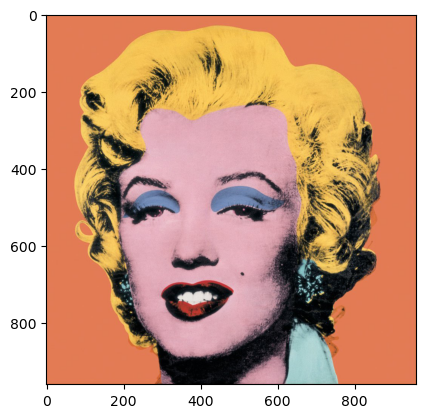

In [11]:
# Convert image to matrix
image_matrix_orange = np.array(img_orange)
# Display the shape of the matrix
print(image_matrix_orange.shape)
img_orange = cv2.cvtColor(img_orange, cv2.COLOR_BGR2RGB)
plt.imshow(img_orange)
plt.show()

In [12]:
#convert imgage to hsv type
hsv_img_orange = cv2.cvtColor(img_orange, cv2.COLOR_RGB2HSV)

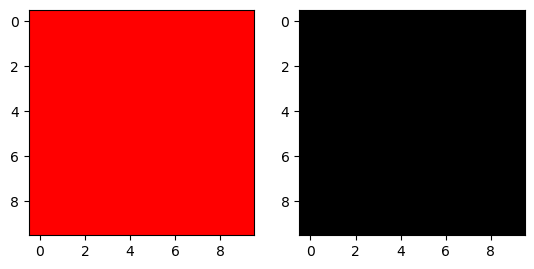

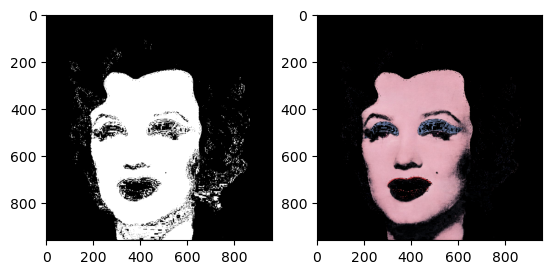

In [13]:
#define range for background orange
light = (110, 40, 0)
dark = (255, 255, 255)
lo_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

#get selected region
mask = cv2.inRange(hsv_img_orange, light, dark)
background = cv2.bitwise_and(img_orange, img_orange, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(background)
plt.show()

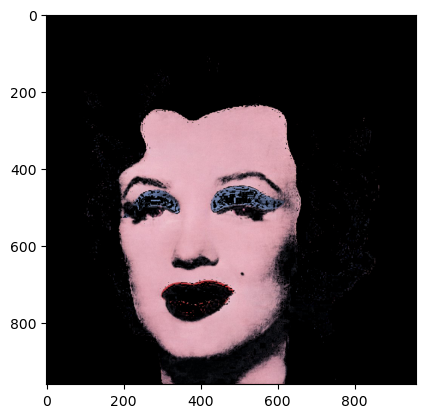

In [14]:
plt.imshow(background)

In [15]:
#Convert the HSV image to RGB
df_temp = get_pixel_Data(orange_link)
df_temp[["Red", "Green", "Blue"]] = df_temp[["Red", "Green", "Blue"]] * 256
rgb_bk = cv2.cvtColor(background, cv2.COLOR_HSV2BGR)
#Extract the individual color channels
red_channel = rgb_bk[:,:,2]
green_channel = rgb_bk[:,:,1]
blue_channel = rgb_bk[:,:,0]
df1 = pd.DataFrame({"Red_int": red_channel.flatten(), 
                    "Green_int": green_channel.flatten(), 
                    "Blue_int": blue_channel.flatten()})
df1[["Red1", "Green1", "Blue1"]] = df_temp[["Red", "Green", "Blue"]]
df1 = df1[(df1['Red_int'] != 0) & (df1['Green_int'] != 0) & (df1['Blue_int'] != 0)]

#Remove duplicate rows based on the specified columns
df1[["Red1", "Green1", "Blue1"]] = df1[["Red1", "Green1", "Blue1"]].astype(int)
df1.drop_duplicates(subset=['Red1', 'Green1', 'Blue1'], keep='first', inplace=True)

#Remove columns Red_int,Green_int,Blue_int
columns_to_remove = ["Red_int","Green_int","Blue_int"]
df1 = df1.drop(columns=columns_to_remove)
df1.reset_index(drop=True, inplace=True)
df1.columns = ["Red","Green", "Blue"]
df1

Red  Green  Blue
0       41     37    51
1       35     29    30
2       45     45    60
3       44     37    58
4       32     24    34
...    ...    ...   ...
41834  167    111   125
41835  144     96   109
41836  115     71    85
41837   96     58    71
41838   92     59    71

[41839 rows x 3 columns]

In [16]:
face1 = get_df_cluster(df1)


  0%|          | 0/41839 [00:00<?, ?it/s]

In [17]:
n = len(face1)
lst_color = []
for i in range(0,n):
    color_name = webcolors.rgb_to_hex((face1['Red center'][i].astype(int),face1['Green center'][i].astype(int),face1['Blue center'][i].astype(int)))
    lst_color.append(color_name)
face1['colour'] = lst_color

<Figure size 640x480 with 0 Axes>

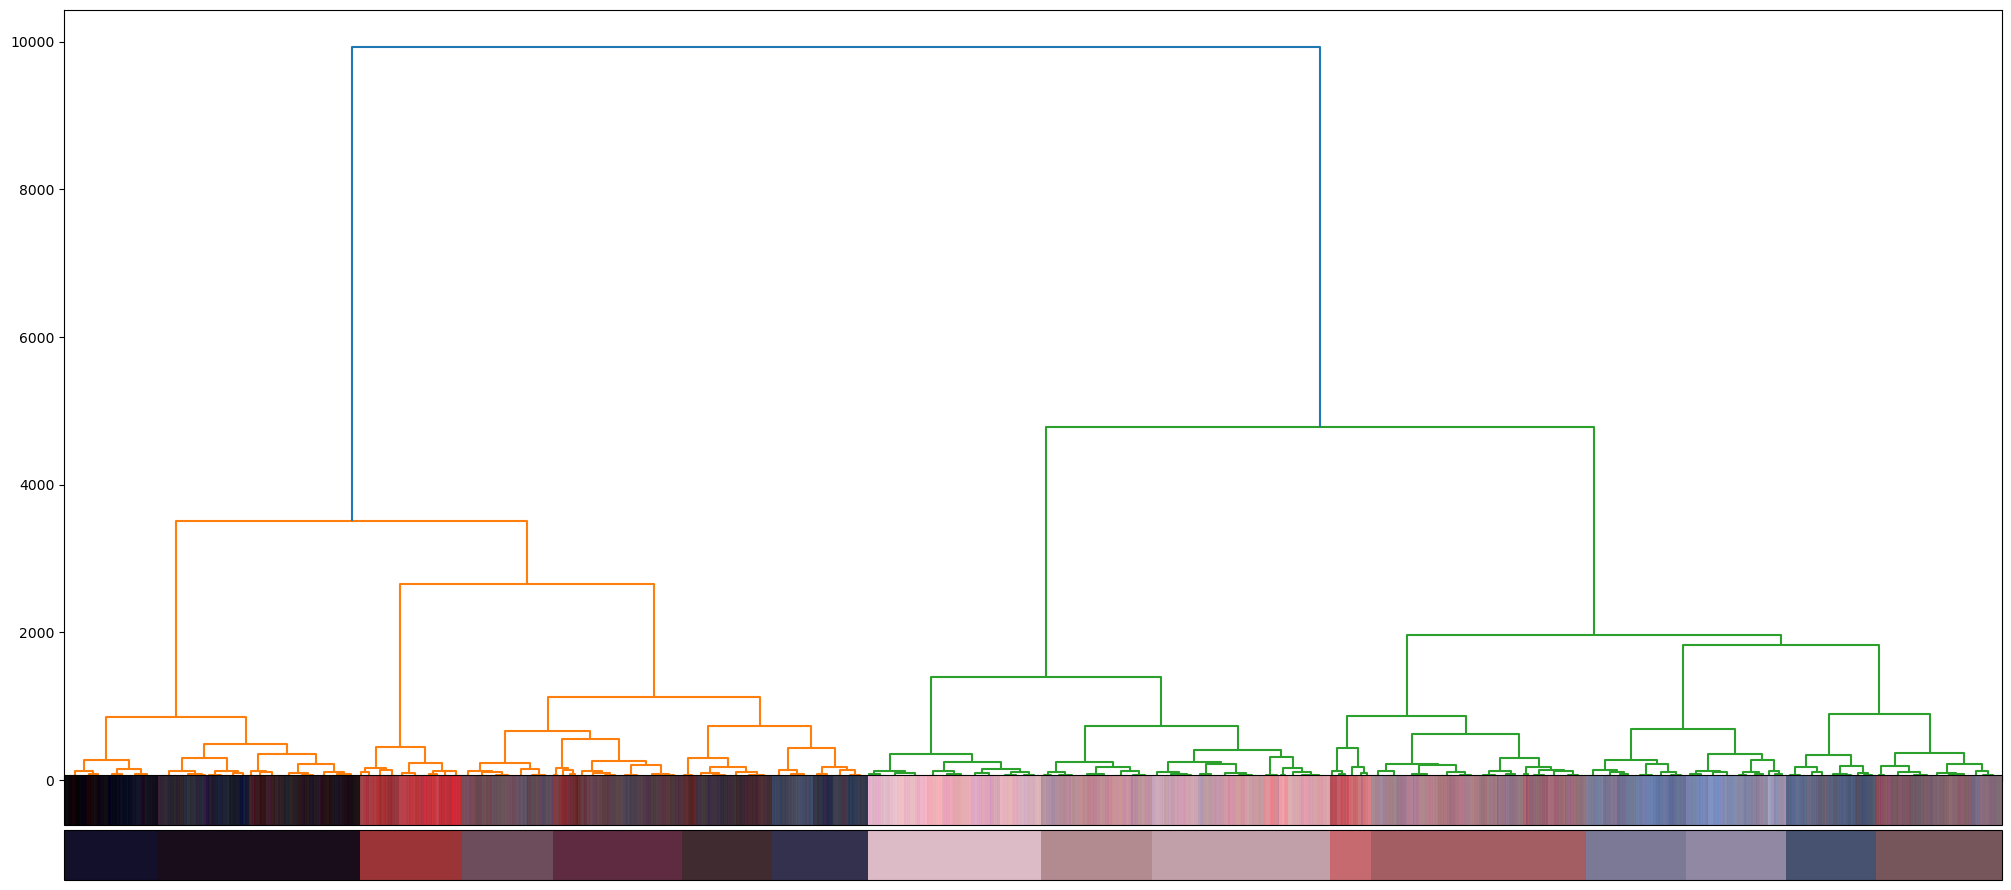

In [18]:
cluster_center_df = cluster_center(df=face1, center_cols=['Red center', 'Green center', 'Blue center'], n_cluster=16)

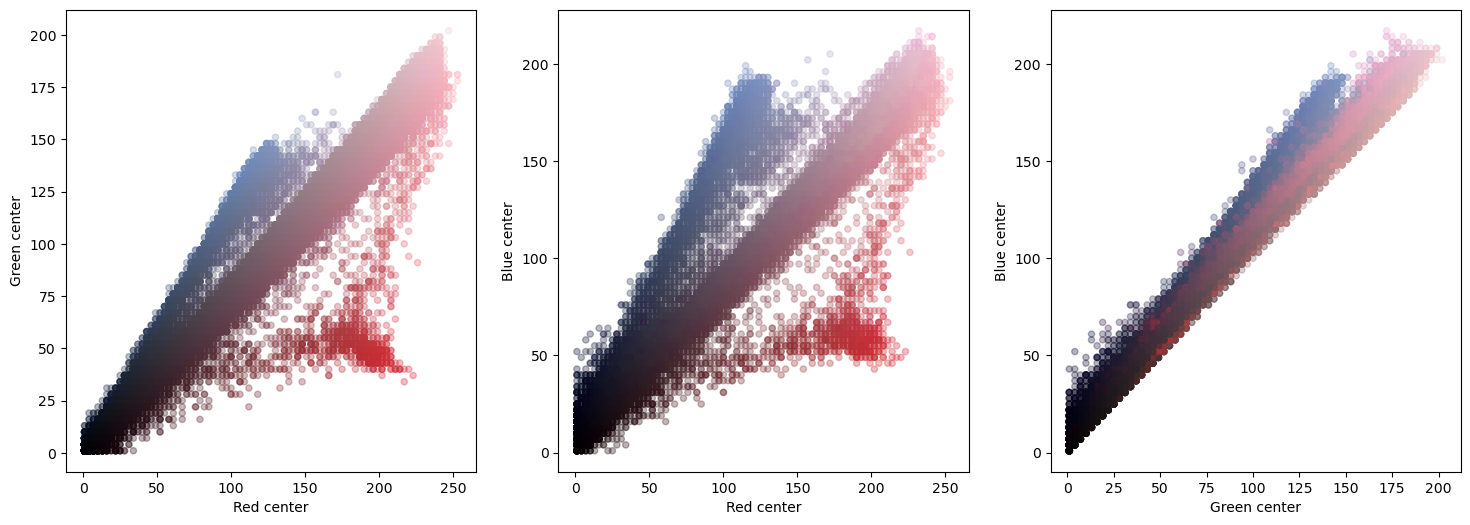

In [211]:
plot_colours(face1,'Red center', 'Green center', 'Blue center')

## Red Face

In [192]:
req = urllib.request.urlopen(red_link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_red = cv2.imdecode(arr, -1) # 'Load it as it is'

(960, 960, 4)


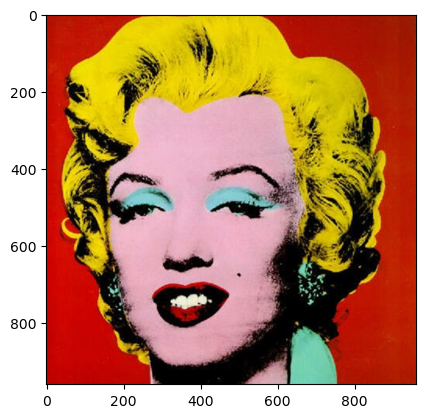

In [193]:
# Convert image to matrix
image_matrix_red = np.array(img_red)
# Display the shape of the matrix
print(image_matrix_red.shape)
img_red = cv2.cvtColor(img_red, cv2.COLOR_BGR2RGB)
plt.imshow(img_red)
plt.show()

In [194]:
#convert imgage to hsv type
hsv_img_red = cv2.cvtColor(img_red, cv2.COLOR_RGB2HSV)

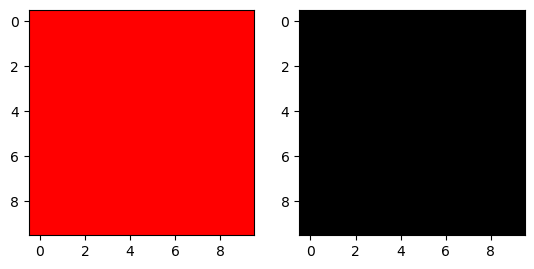

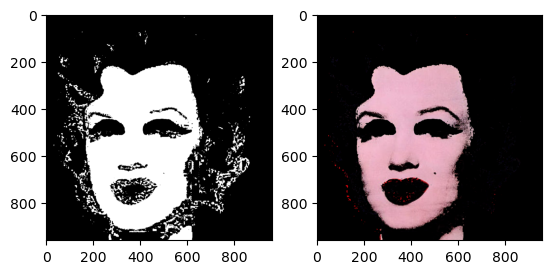

In [216]:
#define range for face
light = (110, 40, 0)
dark = (255, 255, 255)
lo_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

#get selected region
mask = cv2.inRange(hsv_img_red, light, dark)
background1 = cv2.bitwise_and(img_red, img_red, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(background1)
plt.show()

In [217]:
#Convert the HSV image to RGB
df_temp = get_pixel_Data(red_link)
df_temp[["Red", "Green", "Blue"]] = df_temp[["Red", "Green", "Blue"]] * 256
rgb_bk = cv2.cvtColor(background1, cv2.COLOR_HSV2BGR)
#Extract the individual color channels
red_channel = rgb_bk[:,:,2]
green_channel = rgb_bk[:,:,1]
blue_channel = rgb_bk[:,:,0]
df1 = pd.DataFrame({"Red_int": red_channel.flatten(), 
                    "Green_int": green_channel.flatten(), 
                    "Blue_int": blue_channel.flatten()})
df1[["Red1", "Green1", "Blue1"]] = df_temp[["Red", "Green", "Blue"]]
df1 = df1[(df1['Red_int'] != 0) & (df1['Green_int'] != 0) & (df1['Blue_int'] != 0)]

#Remove duplicate rows based on the specified columns
df1[["Red1", "Green1", "Blue1"]] = df1[["Red1", "Green1", "Blue1"]].astype(int)
df1.drop_duplicates(subset=['Red1', 'Green1', 'Blue1'], keep='first', inplace=True)

#Remove columns Red_int,Green_int,Blue_int
columns_to_remove = ["Red_int","Green_int","Blue_int"]
df1 = df1.drop(columns=columns_to_remove)
df1.reset_index(drop=True, inplace=True)
df1.columns = ["Red","Green", "Blue"]
df1

Red  Green  Blue
0      186     16    19
1      185     15    18
2      184     13    19
3      180     12    17
4      182     13    18
...    ...    ...   ...
46709  210    171   177
46710  205    167   172
46711  204    165   170
46712  202    164   168
46713  196    163   165

[46714 rows x 3 columns]

In [218]:
face1 = get_df_cluster(df1)
n = len(face1)
lst_color = []
for i in range(0,n):
    color_name = webcolors.rgb_to_hex((face1['Red center'][i].astype(int),face1['Green center'][i].astype(int),face1['Blue center'][i].astype(int)))
    lst_color.append(color_name)
face1['colour'] = lst_color

  0%|          | 0/46714 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

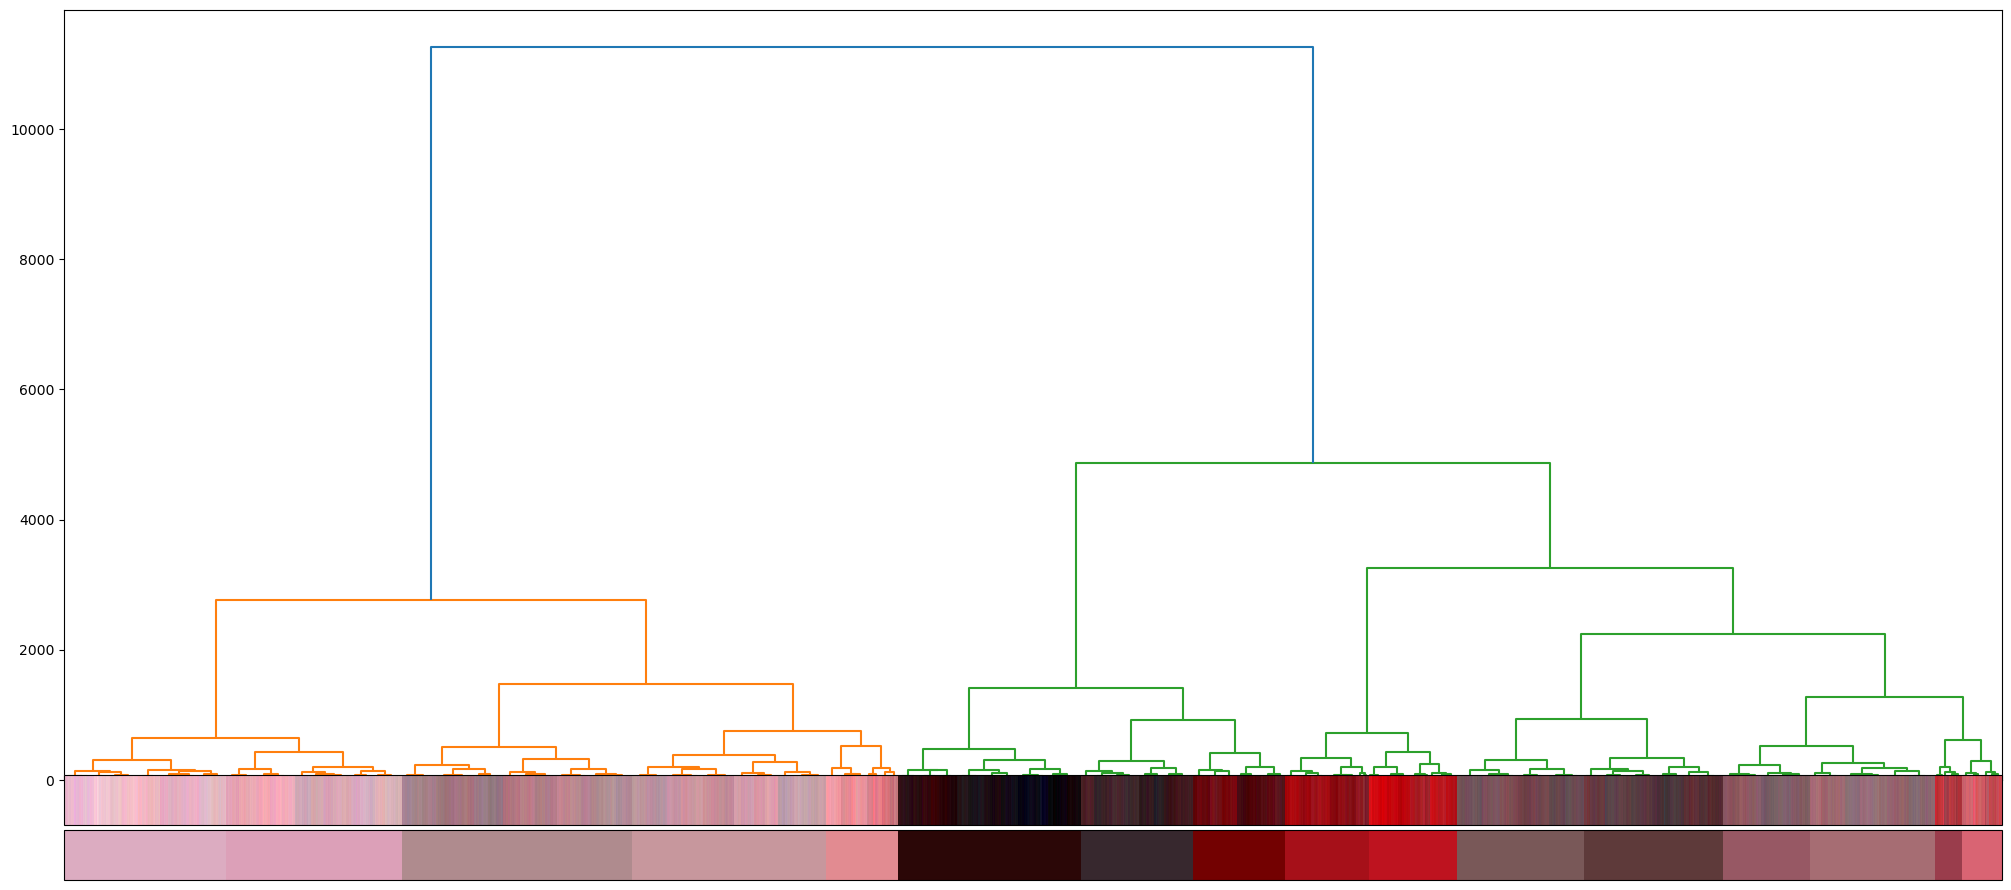

In [219]:
cluster_center_df = cluster_center(df=face1, center_cols=['Red center', 'Green center', 'Blue center'], n_cluster=16)

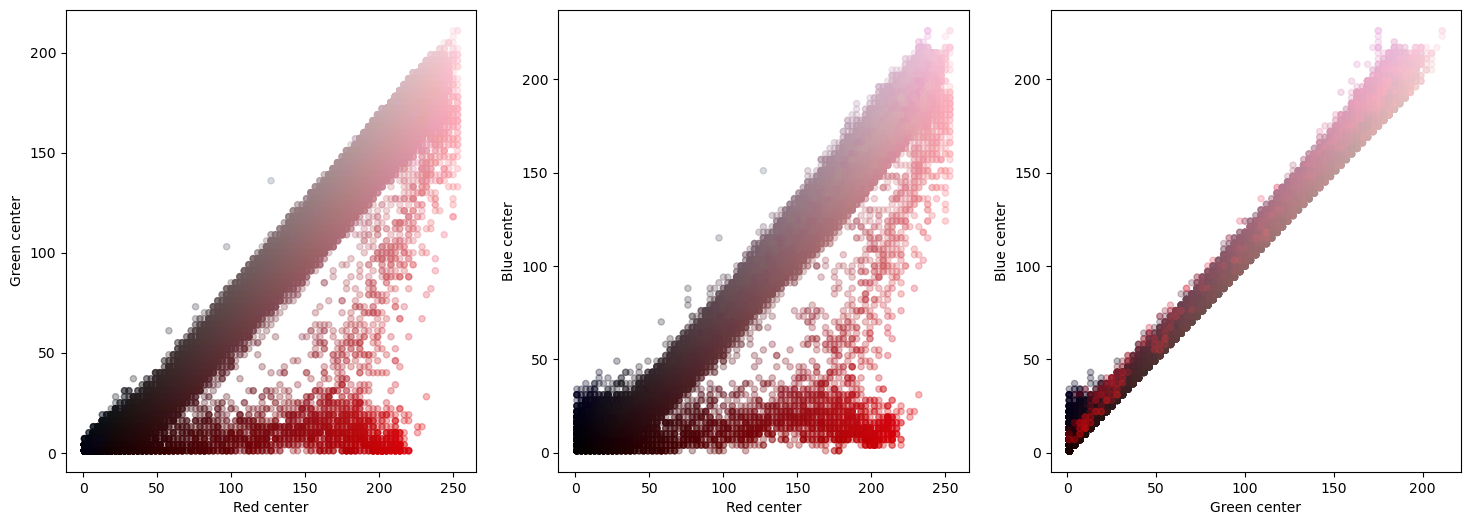

In [220]:
plot_colours(face1,'Red center', 'Green center', 'Blue center')

## Turq Face

In [19]:
req = urllib.request.urlopen(turq_link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_turq = cv2.imdecode(arr, -1) # 'Load it as it is'

(960, 960, 4)


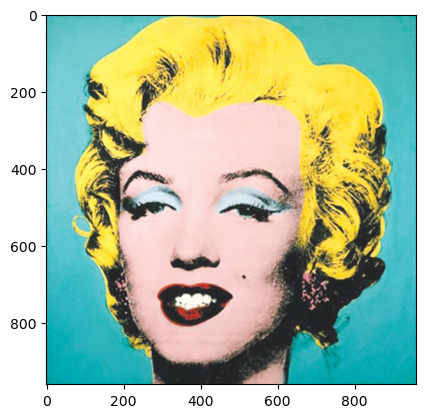

In [20]:
# Convert image to matrix
image_matrix_turq = np.array(img_turq)
# Display the shape of the matrix
print(image_matrix_turq.shape)
img_turq = cv2.cvtColor(img_turq, cv2.COLOR_BGR2RGB)
plt.imshow(img_turq)
plt.show()

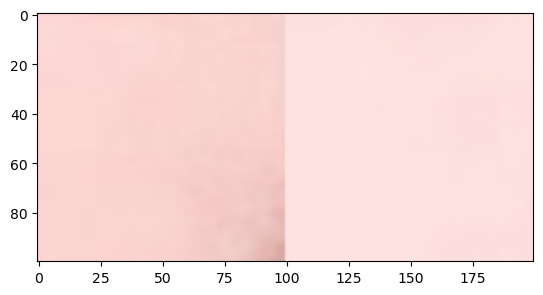

In [223]:
# Define the coordinates of the region of interest (ROI)

x1, x2 = 490, 590
y1, y2 = 550, 650


x3, x4 = 300, 400
y3, y4 = 300, 400



# Crop the image
cropped_image = img_turq[y1:y2, x1:x2]
cropped_image2= img_turq[y3:y4, x3:x4]

#merge picture
im_h = cv2.hconcat([cropped_image, cropped_image2])
plt.imshow(im_h)
plt.show()

In [224]:
find_color_range(im_h)

((0, 26, 215), (179, 64, 255))

In [21]:
#convert imgage to hsv type
hsv_img_turq = cv2.cvtColor(img_turq, cv2.COLOR_RGB2HSV)

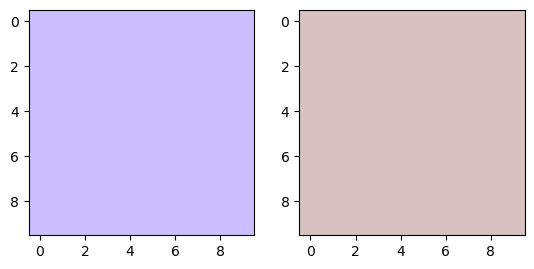

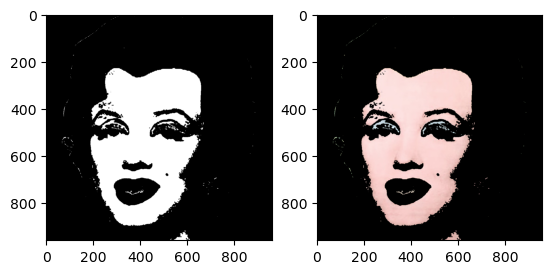

In [22]:
#define range for face
light = (0, 26, 215)
dark = (179, 64, 255)
lo_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

#get selected region
mask = cv2.inRange(hsv_img_turq, light, dark)
background1 = cv2.bitwise_and(img_turq, img_turq, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(background1)
plt.show()

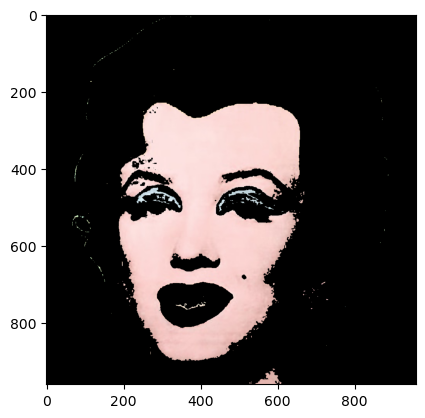

In [23]:
plt.imshow(background1)

In [24]:
#Convert the HSV image to RGB
df_temp = get_pixel_Data(turq_link)
df_temp[["Red", "Green", "Blue"]] = df_temp[["Red", "Green", "Blue"]] * 256
rgb_bk = cv2.cvtColor(background1, cv2.COLOR_HSV2BGR)
#Extract the individual color channels
red_channel = rgb_bk[:,:,2]
green_channel = rgb_bk[:,:,1]
blue_channel = rgb_bk[:,:,0]
df1 = pd.DataFrame({"Red_int": red_channel.flatten(), 
                    "Green_int": green_channel.flatten(), 
                    "Blue_int": blue_channel.flatten()})
df1[["Red1", "Green1", "Blue1"]] = df_temp[["Red", "Green", "Blue"]]
df1 = df1[(df1['Red_int'] != 0) & (df1['Green_int'] != 0) & (df1['Blue_int'] != 0)]

#Remove duplicate rows based on the specified columns
df1[["Red1", "Green1", "Blue1"]] = df1[["Red1", "Green1", "Blue1"]].astype(int)
df1.drop_duplicates(subset=['Red1', 'Green1', 'Blue1'], keep='first', inplace=True)

#Remove columns Red_int,Green_int,Blue_int
columns_to_remove = ["Red_int","Green_int","Blue_int"]
df1 = df1.drop(columns=columns_to_remove)
df1.reset_index(drop=True, inplace=True)
df1.columns = ["Red","Green", "Blue"]
df1

Red  Green  Blue
0      182    216   162
1      177    218   163
2      172    218   164
3      169    217   164
4      166    215   163
...    ...    ...   ...
12266  224    176   168
12267  216    179   169
12268  215    176   170
12269  215    177   171
12270  221    169   166

[12271 rows x 3 columns]

In [237]:
face3 = get_df_cluster(df1)
face3

  0%|          | 0/12271 [00:00<?, ?it/s]

Red  Green  Blue  Red center  Green center  Blue center
0      182    216   162         181           214          160
1      177    218   163         175           217          163
2      172    218   164         172           217          163
3      169    217   164         169           217          163
4      166    215   163         166           214          163
...    ...    ...   ...         ...           ...          ...
12266  224    176   168         223           175          166
12267  216    179   169         214           178          169
12268  215    176   170         214           175          169
12269  215    177   171         214           175          169
12270  221    169   166         220           169          166

[12271 rows x 6 columns]

In [238]:
n = len(face3)
lst_color = []
for i in range(0,n):
    color_name = webcolors.rgb_to_hex((face3['Red center'][i].astype(int),face3['Green center'][i].astype(int),face3['Blue center'][i].astype(int)))
    lst_color.append(color_name)
face3['colour'] = lst_color
face3

Red  Green  Blue  Red center  Green center  Blue center   colour
0      182    216   162         181           214          160  #b5d6a0
1      177    218   163         175           217          163  #afd9a3
2      172    218   164         172           217          163  #acd9a3
3      169    217   164         169           217          163  #a9d9a3
4      166    215   163         166           214          163  #a6d6a3
...    ...    ...   ...         ...           ...          ...      ...
12266  224    176   168         223           175          166  #dfafa6
12267  216    179   169         214           178          169  #d6b2a9
12268  215    176   170         214           175          169  #d6afa9
12269  215    177   171         214           175          169  #d6afa9
12270  221    169   166         220           169          166  #dca9a6

[12271 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

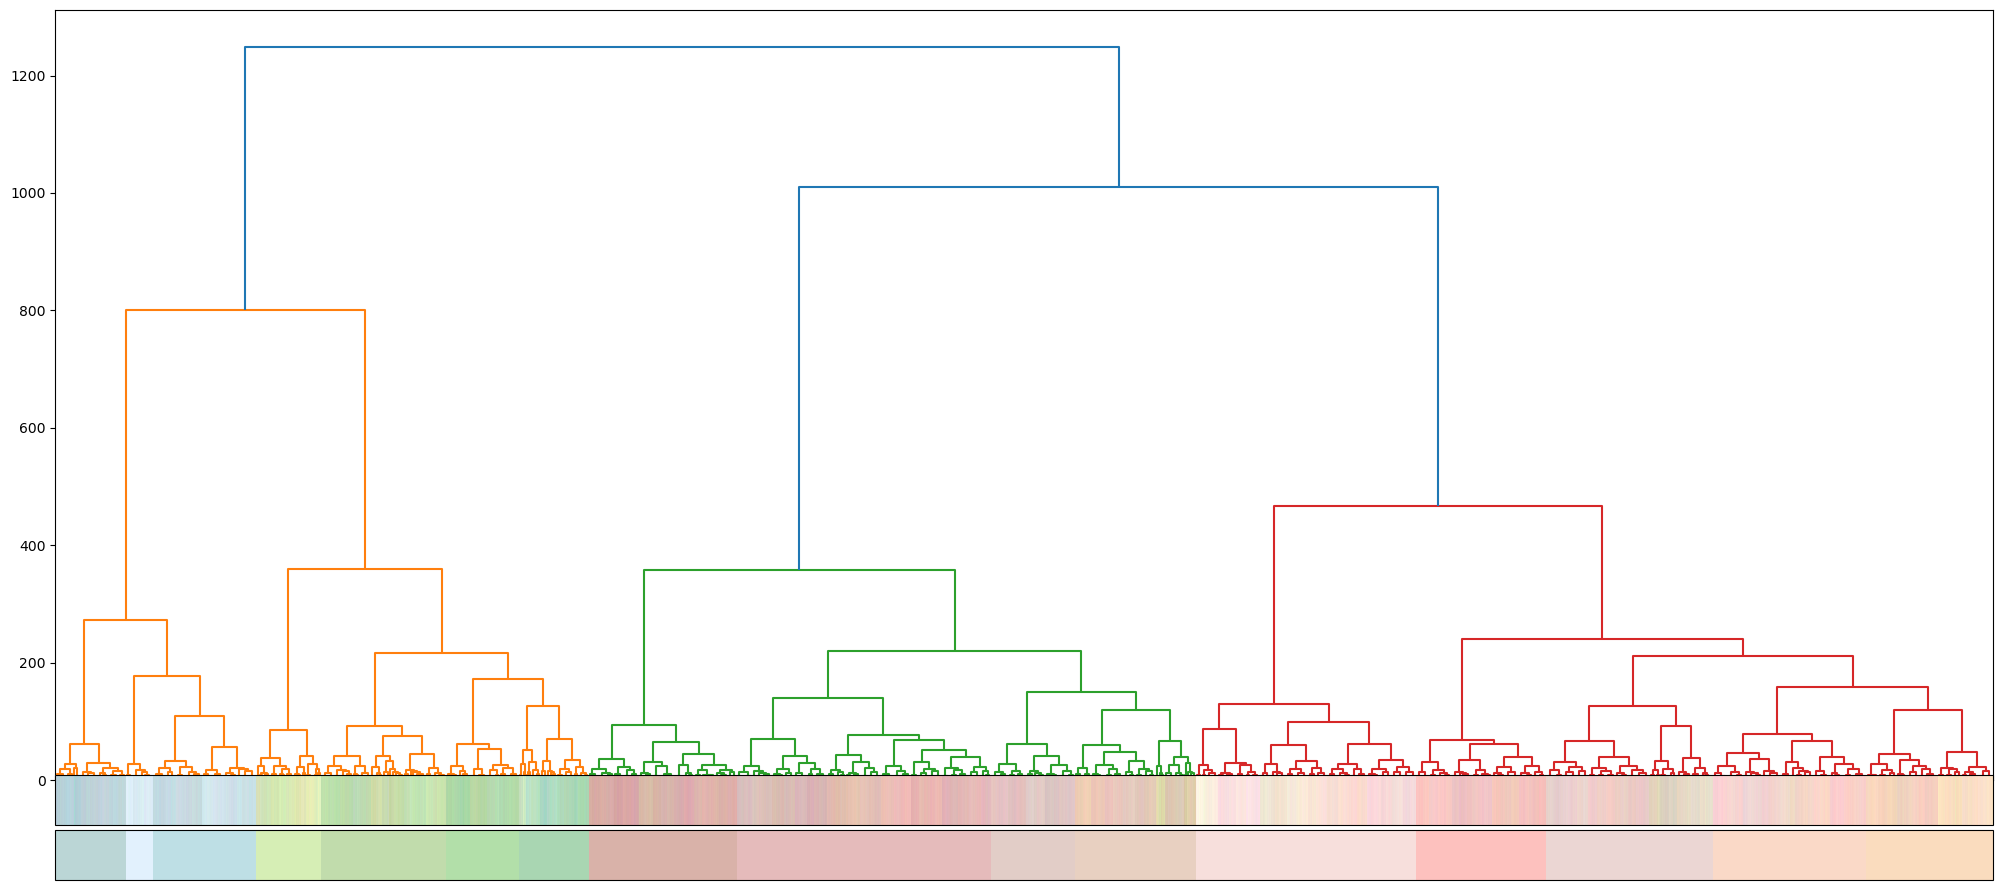

In [239]:
cluster_center_df = cluster_center(df=face3, center_cols=['Red center', 'Green center', 'Blue center'], n_cluster=16)

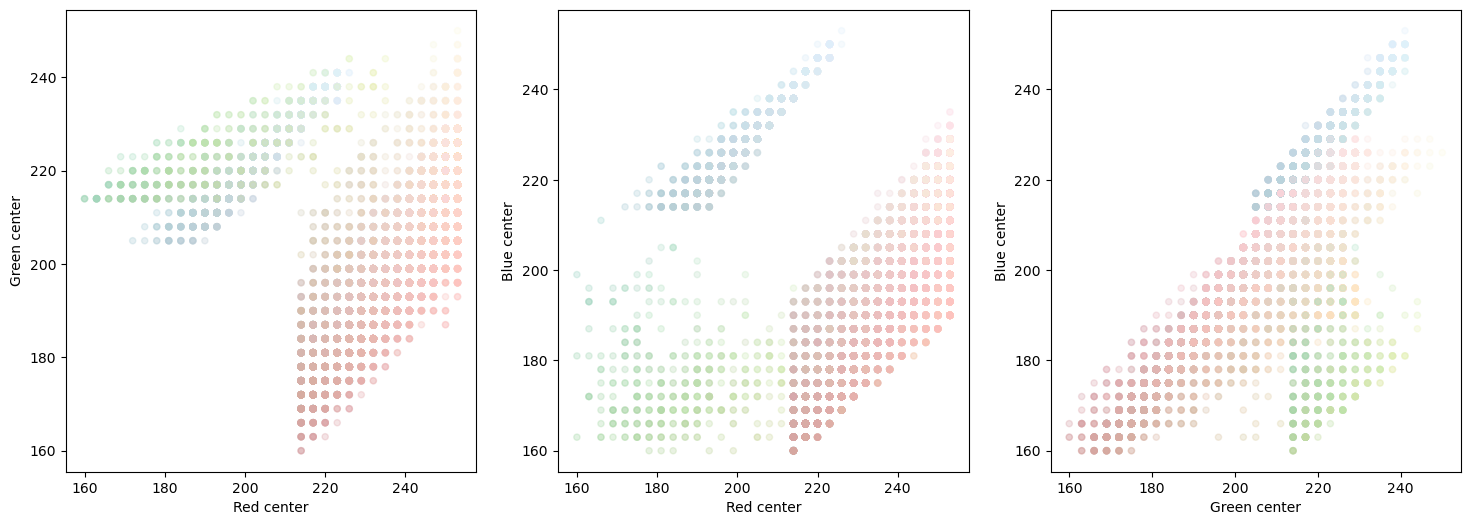

In [240]:
plot_colours(face3,'Red center', 'Green center', 'Blue center')

## Blue Face

In [25]:
req = urllib.request.urlopen(blue_link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_blue = cv2.imdecode(arr, -1) # 'Load it as it is'

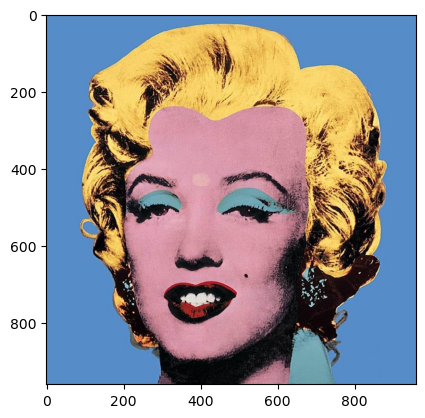

In [26]:
# Convert image to matrix
image_matrix_blue = np.array(img_blue)
img_blue = cv2.cvtColor(img_blue, cv2.COLOR_BGR2RGB)
plt.imshow(img_blue)
plt.show()

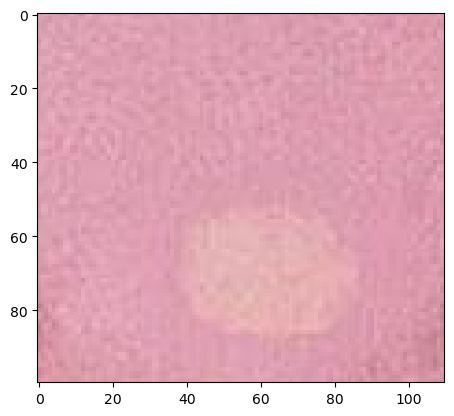

In [326]:
# Define the coordinates of the region of interest (ROI)
x1, x2 = 340, 450 
y1, y2 = 360,  460


# Crop the image
cropped_image = img_blue[y1:y2, x1:x2] 
#cropped_image2 = img[y3:y4, x3:x4]


#im_h = cv2.hconcat([cropped_image, cropped_image2])
plt.imshow(cropped_image)
plt.show()

In [327]:
# Load the image
image = cropped_image
# Find the color range in the image
color_range_min, color_range_max = find_color_range(image)

# Print the minimum and maximum values for each channel
h_min, s_min, v_min = color_range_min
h_max, s_max, v_max = color_range_max
print(f"Color Range (Min): H={h_min}, S={s_min}, V={v_min}")
print(f"Color Range (Max): H={h_max}, S={s_max}, V={v_max}")

Color Range (Min): H=0, S=50, V=192
Color Range (Max): H=179, S=90, V=242


In [328]:
# Find the color range in the image
color_range_min, color_range_max = find_color_range(image)
color_range_min = convert_to_numerical_tuple(color_range_min)
color_range_max = convert_to_numerical_tuple(color_range_max)

In [27]:
#convert imgage to hsv type
hsv_img_blue = cv2.cvtColor(img_blue, cv2.COLOR_RGB2HSV)

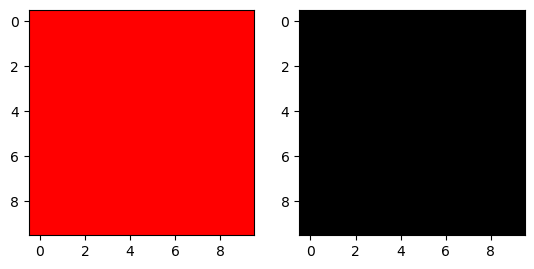

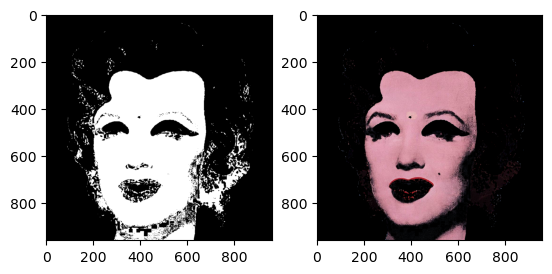

In [28]:
#define range for background orange
light_orange = (110, 40, 0)
dark_orange = (255, 255, 255)
lo_square = np.full((10, 10, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_orange, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

#get selected region
mask = cv2.inRange(hsv_img_blue, light_orange, dark_orange)
background1 = cv2.bitwise_and(img_blue, img_blue, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(background1)
plt.show()

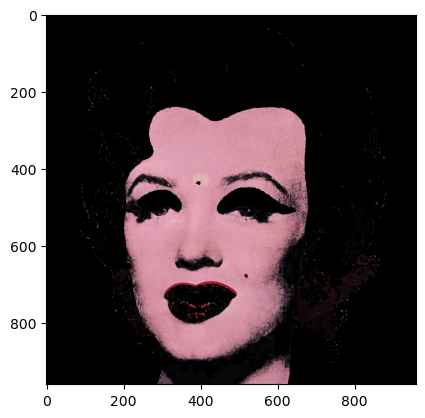

In [29]:
plt.imshow(background1)

In [30]:
#Convert the HSV image to RGB
df_temp = get_pixel_Data(blue_link)
df_temp[["Red", "Green", "Blue"]] = df_temp[["Red", "Green", "Blue"]] * 256
rgb_bk = cv2.cvtColor(background1, cv2.COLOR_HSV2BGR)
#Extract the individual color channels
red_channel = rgb_bk[:,:,2]
green_channel = rgb_bk[:,:,1]
blue_channel = rgb_bk[:,:,0]
df1 = pd.DataFrame({"Red_int": red_channel.flatten(), 
                    "Green_int": green_channel.flatten(), 
                    "Blue_int": blue_channel.flatten()})
df1[["Red1", "Green1", "Blue1"]] = df_temp[["Red", "Green", "Blue"]]
df1 = df1[(df1['Red_int'] != 0) & (df1['Green_int'] != 0) & (df1['Blue_int'] != 0)]

#Remove duplicate rows based on the specified columns
df1[["Red1", "Green1", "Blue1"]] = df1[["Red1", "Green1", "Blue1"]].astype(int)
df1.drop_duplicates(subset=['Red1', 'Green1', 'Blue1'], keep='first', inplace=True)

#Remove columns Red_int,Green_int,Blue_int
columns_to_remove = ["Red_int","Green_int","Blue_int"]
df1 = df1.drop(columns=columns_to_remove)
df1.reset_index(drop=True, inplace=True)
df1.columns = ["Red","Green", "Blue"]
df1

Red  Green  Blue
0      107    133   184
1      115    127   167
2      116    129   171
3      113    132   175
4      123    130   149
...    ...    ...   ...
27310  178    108   118
27311  207    132   155
27312  202    124   148
27313  190    135   156
27314  179    140   159

[27315 rows x 3 columns]

In [31]:
face4 = get_df_cluster(df1)
face4

  0%|          | 0/27315 [00:00<?, ?it/s]

Red  Green  Blue  Red center  Green center  Blue center
0      107    133   184         106           133          184
1      115    127   167         115           127          166
2      116    129   171         115           127          169
3      113    132   175         112           130          175
4      123    130   149         121           130          148
...    ...    ...   ...         ...           ...          ...
27310  178    108   118         178           106          118
27311  207    132   155         205           130          154
27312  202    124   148         202           124          148
27313  190    135   156         190           133          154
27314  179    140   159         178           139          157

[27315 rows x 6 columns]

In [32]:
n = len(face4)
lst_color = []
for i in range(0,n):
    color_name = webcolors.rgb_to_hex((face4['Red center'][i].astype(int),face4['Green center'][i].astype(int),face4['Blue center'][i].astype(int)))
    lst_color.append(color_name)
face4['colour'] = lst_color
face4

Red  Green  Blue  Red center  Green center  Blue center   colour
0      107    133   184         106           133          184  #6a85b8
1      115    127   167         115           127          166  #737fa6
2      116    129   171         115           127          169  #737fa9
3      113    132   175         112           130          175  #7082af
4      123    130   149         121           130          148  #798294
...    ...    ...   ...         ...           ...          ...      ...
27310  178    108   118         178           106          118  #b26a76
27311  207    132   155         205           130          154  #cd829a
27312  202    124   148         202           124          148  #ca7c94
27313  190    135   156         190           133          154  #be859a
27314  179    140   159         178           139          157  #b28b9d

[27315 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

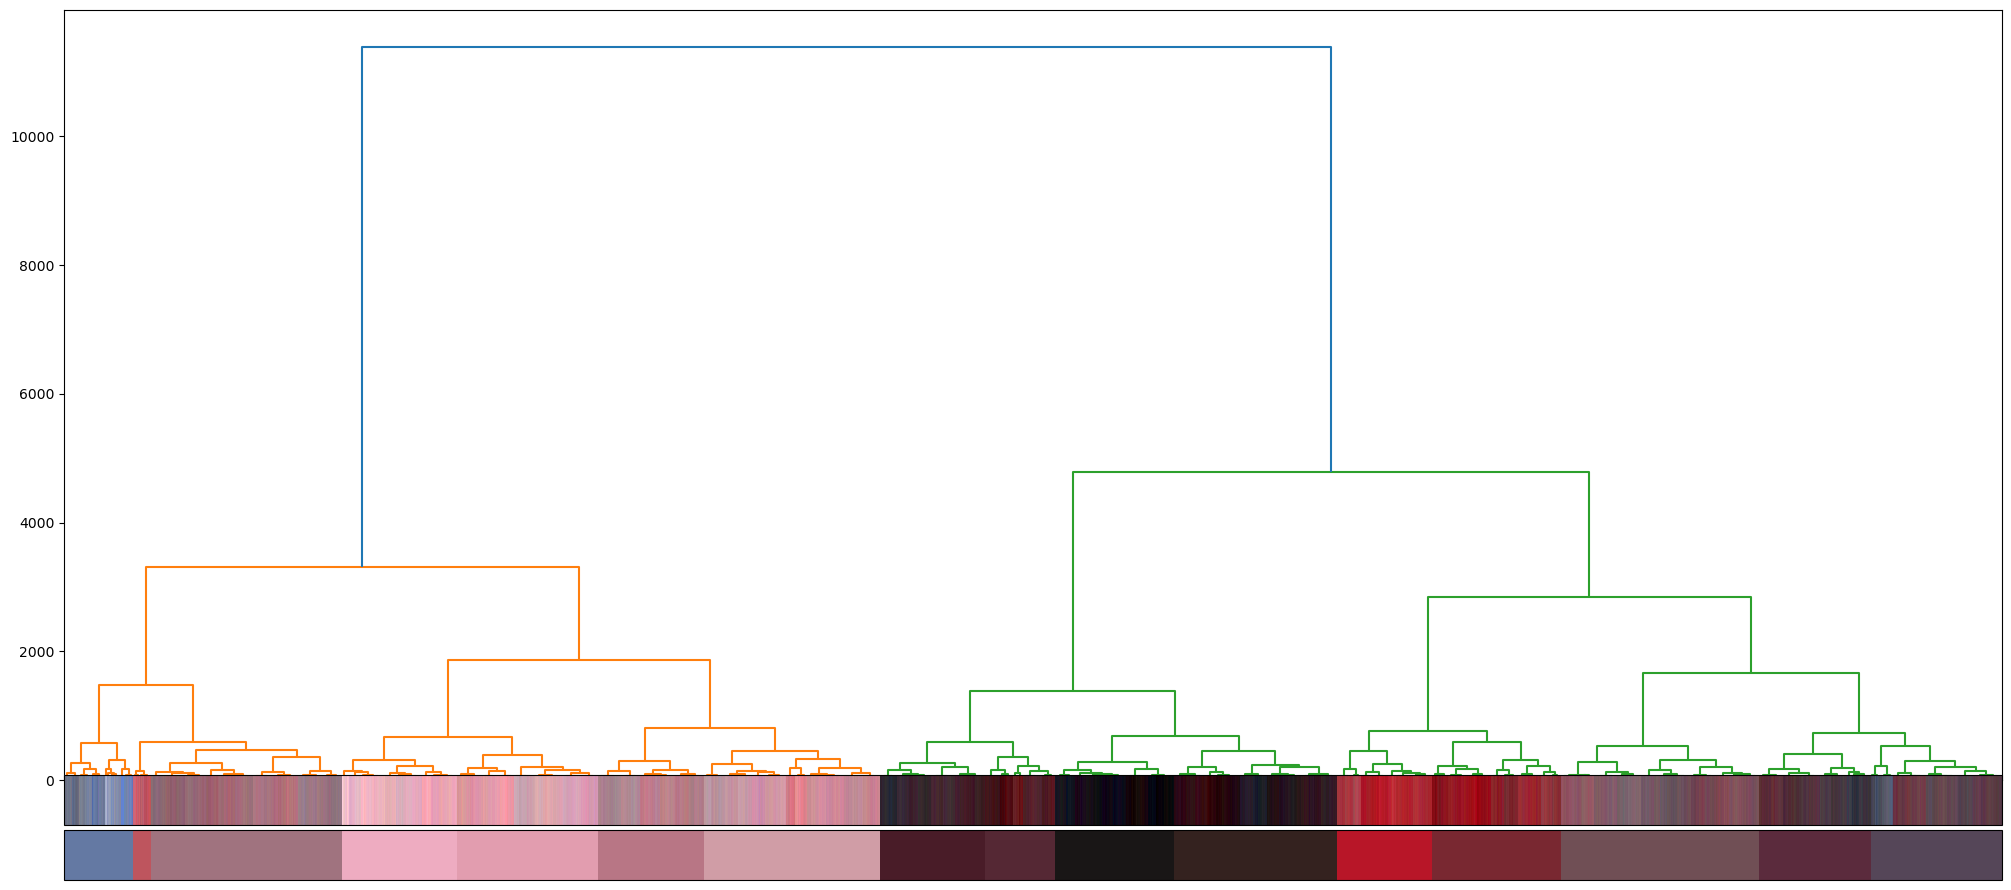

In [33]:
cluster_center_df = cluster_center(df=face4, center_cols=['Red center', 'Green center', 'Blue center'], n_cluster=16)

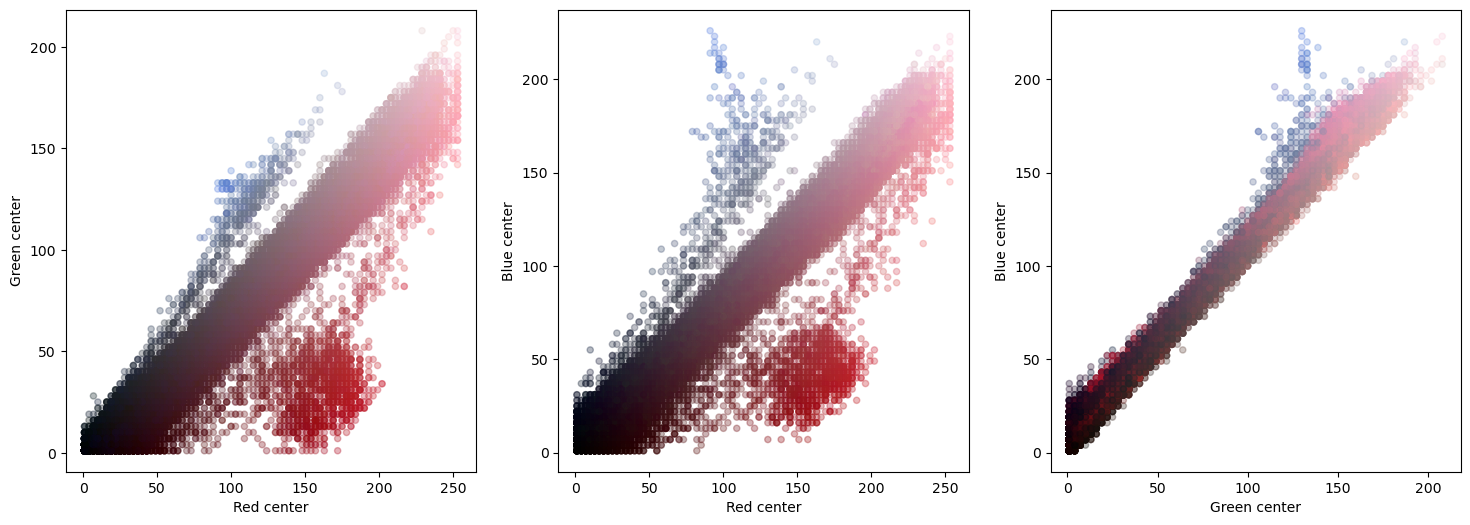

In [34]:
plot_colours(face4,'Red center', 'Green center', 'Blue center')

## Eggblue Face

In [310]:
req = urllib.request.urlopen(eggblue_link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_eggblue = cv2.imdecode(arr, -1) # 'Load it as it is'

(960, 960, 4)


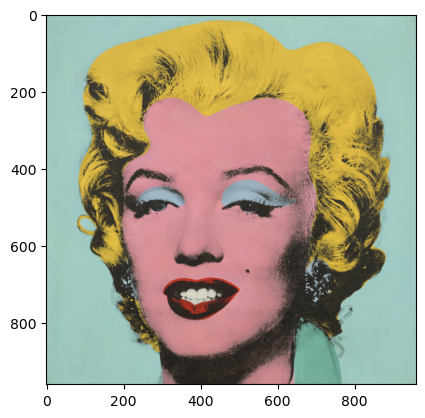

In [311]:
# Convert image to matrix
image_matrix_eggblue = np.array(img_eggblue)
# Display the shape of the matrix
print(image_matrix_turq.shape)
img_eggblue = cv2.cvtColor(img_eggblue, cv2.COLOR_BGR2RGB)
plt.imshow(img_eggblue)
plt.show()

In [312]:
#convert imgage to hsv type
hsv_img_eggblue = cv2.cvtColor(img_eggblue, cv2.COLOR_RGB2HSV)

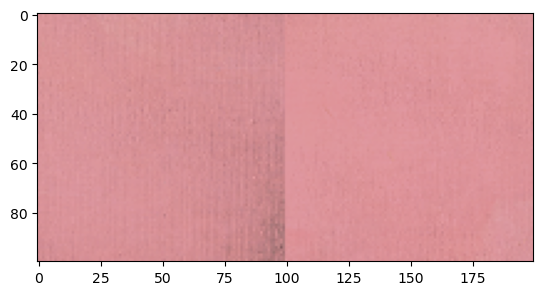

In [313]:
# Define the coordinates of the region of interest (ROI)

x1, x2 = 490, 590
y1, y2 = 550, 650


x3, x4 = 350, 450
y3, y4 = 300, 400



# Crop the image
cropped_image = img_eggblue[y1:y2, x1:x2]
cropped_image2= img_eggblue[y3:y4, x3:x4]

#merge picture
im_h = cv2.hconcat([cropped_image, cropped_image2])
plt.imshow(im_h)
plt.show()

In [314]:
find_color_range(cropped_image)

((0, 72, 133), (179, 93, 231))

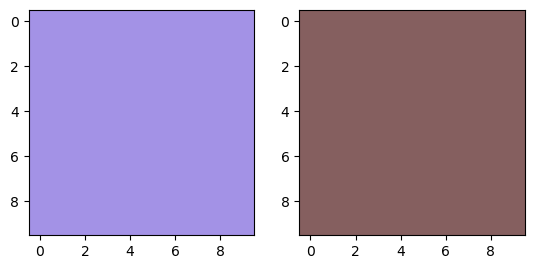

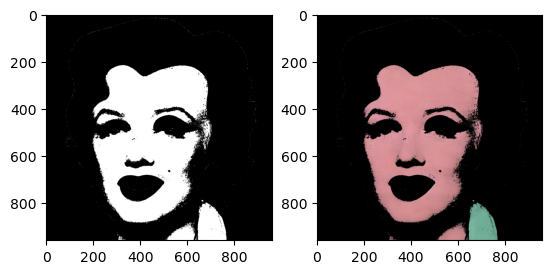

In [317]:
#define range for background orange
light = (0, 72, 133)
dark = (179, 93, 230)
lo_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

#get selected region
mask = cv2.inRange(hsv_img_eggblue, light, dark)
background1 = cv2.bitwise_and(img_eggblue, img_eggblue, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(background1)
plt.show()

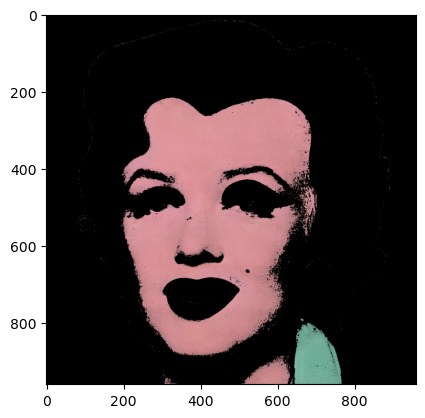

In [318]:
plt.imshow(background1)


In [319]:
#Convert the HSV image to RGB
df_temp = get_pixel_Data(eggblue_link)
df_temp[["Red", "Green", "Blue"]] = df_temp[["Red", "Green", "Blue"]] * 256
rgb_bk = cv2.cvtColor(background1, cv2.COLOR_HSV2BGR)
#Extract the individual color channels
red_channel = rgb_bk[:,:,2]
green_channel = rgb_bk[:,:,1]
blue_channel = rgb_bk[:,:,0]
df1 = pd.DataFrame({"Red_int": red_channel.flatten(), 
                    "Green_int": green_channel.flatten(), 
                    "Blue_int": blue_channel.flatten()})
df1[["Red1", "Green1", "Blue1"]] = df_temp[["Red", "Green", "Blue"]]
df1 = df1[(df1['Red_int'] != 0) & (df1['Green_int'] != 0) & (df1['Blue_int'] != 0)]

#Remove duplicate rows based on the specified columns
df1[["Red1", "Green1", "Blue1"]] = df1[["Red1", "Green1", "Blue1"]].astype(int)
df1.drop_duplicates(subset=['Red1', 'Green1', 'Blue1'], keep='first', inplace=True)

#Remove columns Red_int,Green_int,Blue_int
columns_to_remove = ["Red_int","Green_int","Blue_int"]
df1 = df1.drop(columns=columns_to_remove)
df1.reset_index(drop=True, inplace=True)
df1.columns = ["Red","Green", "Blue"]
df1

Red  Green  Blue
0      193    187   136
1      195    187   127
2      182    187   126
3      181    185   121
4      181    189   131
...    ...    ...   ...
15641  101    148   133
15642  111    162   146
15643  106    157   141
15644  108    161   142
15645  116    162   145

[15646 rows x 3 columns]

In [320]:
face5 = get_df_cluster(df1)
face5

  0%|          | 0/15646 [00:00<?, ?it/s]

Red  Green  Blue  Red center  Green center  Blue center
0      193    187   136         193           187          136
1      195    187   127         193           187          127
2      182    187   126         181           187          124
3      181    185   121         181           184          121
4      181    189   131         181           187          130
...    ...    ...   ...         ...           ...          ...
15641  101    148   133         100           148          133
15642  111    162   146         109           160          145
15643  106    157   141         106           157          139
15644  108    161   142         106           160          142
15645  116    162   145         115           160          145

[15646 rows x 6 columns]

In [321]:
n = len(face5)
lst_color = []
for i in range(0,n):
    color_name = webcolors.rgb_to_hex((face5['Red center'][i].astype(int),face5['Green center'][i].astype(int),face5['Blue center'][i].astype(int)))
    lst_color.append(color_name)
face5['colour'] = lst_color
face5

Red  Green  Blue  Red center  Green center  Blue center   colour
0      193    187   136         193           187          136  #c1bb88
1      195    187   127         193           187          127  #c1bb7f
2      182    187   126         181           187          124  #b5bb7c
3      181    185   121         181           184          121  #b5b879
4      181    189   131         181           187          130  #b5bb82
...    ...    ...   ...         ...           ...          ...      ...
15641  101    148   133         100           148          133  #649485
15642  111    162   146         109           160          145  #6da091
15643  106    157   141         106           157          139  #6a9d8b
15644  108    161   142         106           160          142  #6aa08e
15645  116    162   145         115           160          145  #73a091

[15646 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

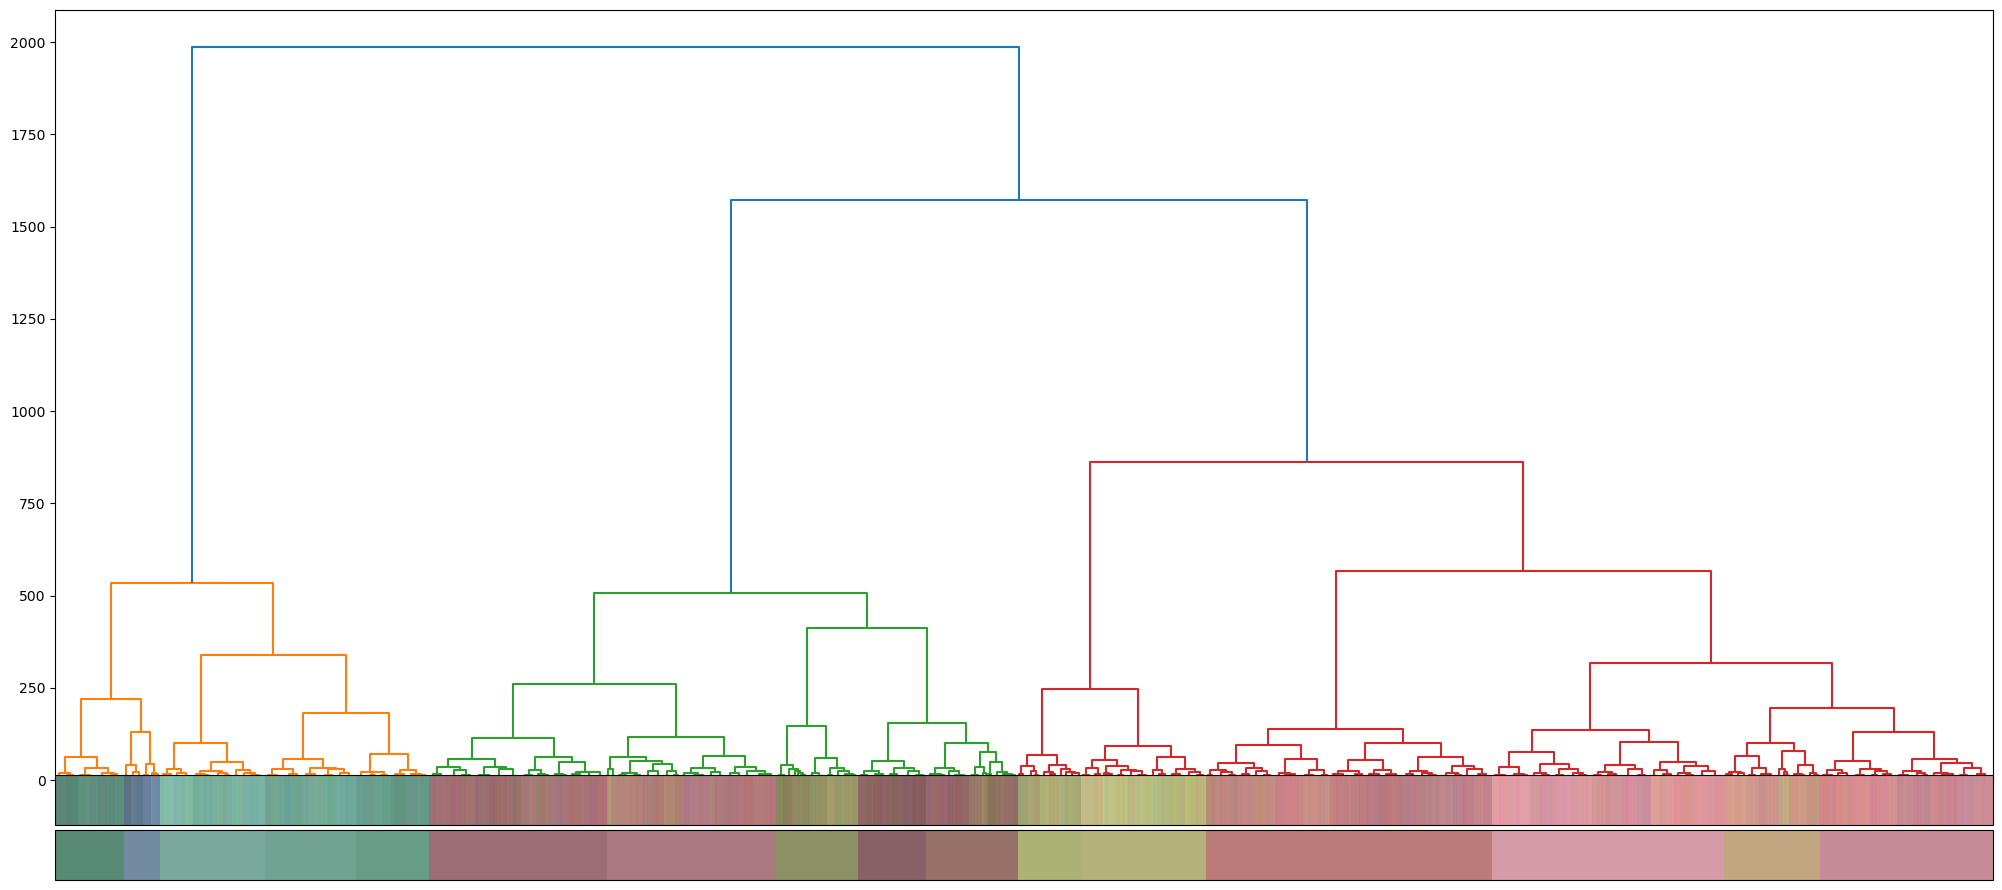

In [322]:
cluster_center_df = cluster_center(df=face5, center_cols=['Red center', 'Green center', 'Blue center'], n_cluster=16)

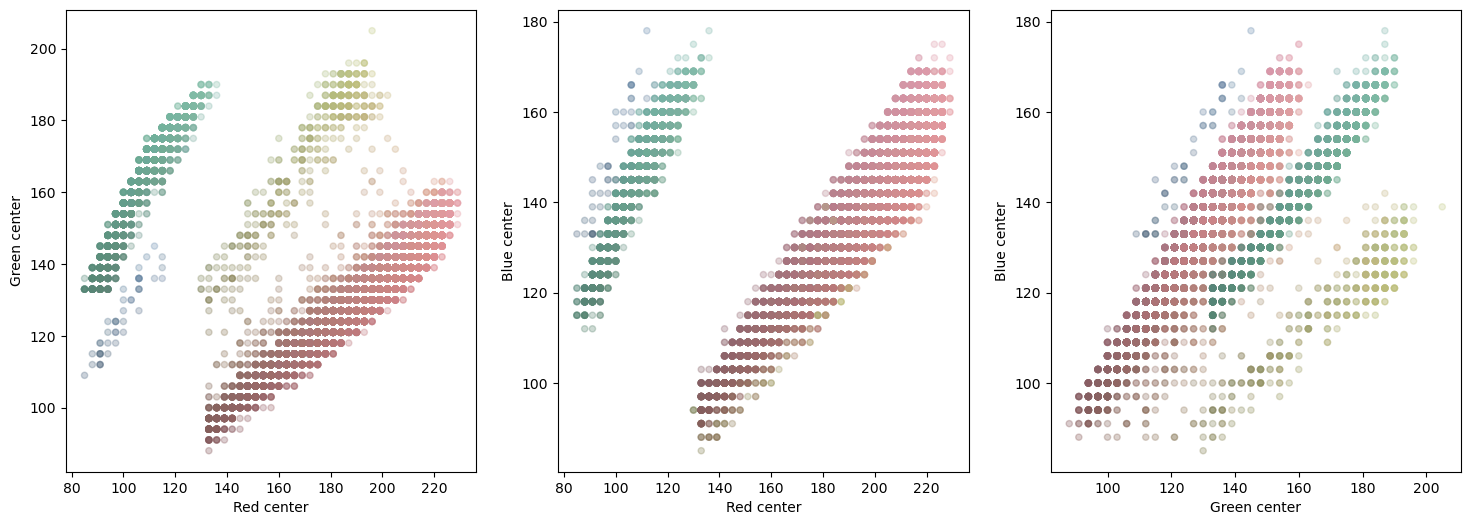

In [323]:
plot_colours(face5,'Red center', 'Green center', 'Blue center')

In [136]:
#convert imgage to hsv type
hsv_img_eggblue = cv2.cvtColor(background, cv2.COLOR_RGB2HSV)

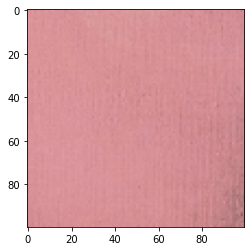

In [133]:
# Define the coordinates of the region of interest (ROI)

x1, x2 = 490, 590
y1, y2 = 550, 650



# Crop the image
cropped_image = img_eggblue[y1:y2, x1:x2]

plt.imshow(cropped_image)
plt.show()

In [134]:
find_color_range(cropped_image)

((0, 72, 133), (179, 93, 231))

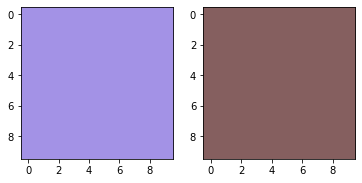

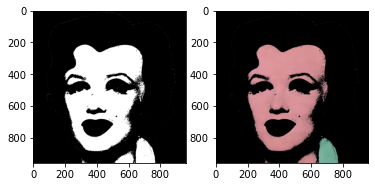

In [137]:
#define range for background orange
light = (0, 72, 133)
dark = (179, 93, 230)
lo_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

#get selected region
mask = cv2.inRange(hsv_img_eggblue, light, dark)
background2 = cv2.bitwise_and(background, background, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(background2)
plt.show()

# Gun Shot (Blue Image)

In [303]:
req = urllib.request.urlopen(blue_link)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img_blue = cv2.imdecode(arr, -1) # 'Load it as it is'

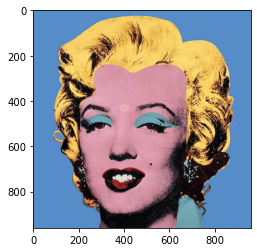

In [304]:
# Convert image to matrix
image_matrix_blue = np.array(img_blue)
img_blue = cv2.cvtColor(img_blue, cv2.COLOR_BGR2RGB)
plt.imshow(img_blue)
plt.show()

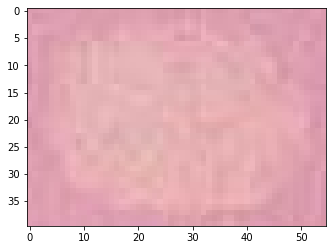

In [305]:
# get the gun shot area
x1, x2 = 375, 430 
y1, y2 = 410,  450

# Crop the image
cropped_image = img_blue[y1:y2, x1:x2] 
#cropped_image2 = img[y3:y4, x3:x4]


#im_h = cv2.hconcat([cropped_image, cropped_image2])
plt.imshow(cropped_image)
plt.show()

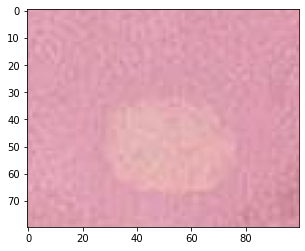

In [306]:
# get the gun shot area
x1, x2 = 350, 450 
y1, y2 = 380, 460

# Crop the image
cropped_image = img_blue[y1:y2, x1:x2] 
#cropped_image2 = img[y3:y4, x3:x4]


#im_h = cv2.hconcat([cropped_image, cropped_image2])
plt.imshow(cropped_image)
plt.show()

In [307]:
# Extract the Red, Green, and Blue channels from the specific area
specific_area = cropped_image
red_channel = specific_area[:, :, 0].flatten()
green_channel = specific_area[:, :, 1].flatten()
blue_channel = specific_area[:, :, 2].flatten()

# Randomly sample RGB values with the same distribution as the specific area for each color channel
sampled_red = np.random.choice(red_channel, size=(40, 55))
sampled_green = np.random.choice(green_channel, size=(40, 55))
sampled_blue = np.random.choice(blue_channel, size=(40, 55))

# Create a new matrix with the sampled RGB values
new_matrix = np.dstack((sampled_red, sampled_green, sampled_blue)).astype(np.uint8)


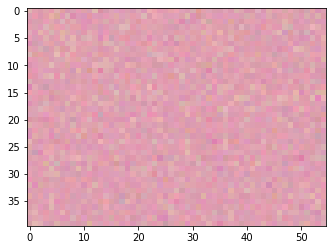

In [308]:
plt.imshow(new_matrix)
plt.show()

In [309]:
new_img_blue = img_blue.copy()
# ROI of gun shot area
x1, x2 = 375, 430 
y1, y2 = 410,  450

# Replace the area in new_img_blue with new_matrix
new_img_blue[y1:y2, x1:x2] = new_matrix

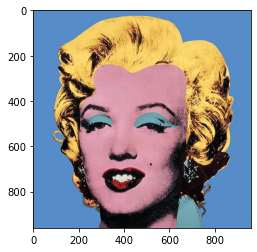

In [310]:
plt.imshow(new_img_blue)
plt.show()